# 0 Init

##  0.1 Runtime Setup  

In [ ]:
# RUN 1
# download and unpack tsnecuda from anaconda.org
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/

# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

--2021-11-26 22:18:40--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20211126T221840Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEM3%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQCOVuJC%2FRAXpyiV6v2nMmZuiTprv6zw0DcWZN181Ggr6QIhAK1cbEnZGfLnlWWFZS9UL9J392ztABguBmmwfto4XBApKoMECJb%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQABoMNDU1ODY0MDk4Mzc4IgwuI

In [ ]:
# RUN 2
!pip install catboost pytorch-tabnet lightgbm

## 0.2 Package Import

In [ ]:
# RUN 3
import numpy as np
import pandas as pd

import seaborn as sns
import math
import random
import os
import time

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import ClassifierMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

from tsnecuda import TSNE
import plotly.express as px
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, pyll
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow.python.profiler import profiler_client
tf.random.set_seed(69)
import missingno
import warnings

from scipy.stats import skew

import pickle

random.seed(10)

# Models
import plotly.express as px
import plotly.graph_objects as go

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import catboost
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn import svm
from lightgbm import LGBMClassifier

from IPython.display import clear_output 

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

try:
  tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
  print(profiler_client.monitor(tpu_profile_service_address, 100, 2))
except KeyError:
  print("Not using TPU")

Num GPUs Available:  1
Not using TPU


## 0.4 Mount google drive

In [ ]:
# RUN 4
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


## 0.5 Data load & init setup

In [ ]:
# RUN 5
# Aidan & Chris & Angel
dfTest = pd.read_csv("/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/test.csv")
dfTrain = pd.read_csv("/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/train.csv")

In [ ]:
# RUN 6
yTrainFull = dfTrain['claim']
TestID = dfTest['id']
dfTest = dfTest.drop(columns=['id'])
dfTrain = dfTrain.drop(columns=['id', 'claim'])

In [ ]:
df = pd.concat([dfTrain, dfTest], axis=0)

# 1 Preprocessing - SKlearn Pipeline

## 1.1 Large File Export

In [ ]:
def preprocess(df, rowCount):

  output = []

  iterativeImputer = IterativeImputer(add_indicator=True)

  # split df into groups of size rowCount
  groups = [df.iloc[i:i+rowCount] for i in range(0,len(df),rowCount)]

  print(f"{len(groups)} groups.")

  # preprocess each frame
  # this is done to save memory
  count = 0 
  for group in groups:
    count = count + len(group.index)
    index = group.index
    print(f"{count} rows of {len(df.index)}")
    precessedFeatures = iterativeImputer.fit_transform(group)
    output.append(pd.DataFrame(precessedFeatures, index=index))
    clear_output()
    

  return pd.concat(output, axis=0)

In [ ]:
dfTrainPre = preprocess(dfTrain.sample(frac=1), 100000)

In [ ]:
dfTrainPre32 = dfTrainPre.astype(np.float32)
dfTrainPre32.to_csv('dfTrainPre.csv',index=True)

In [ ]:
!mv /content/dfTrainPre.csv "/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/"

In [ ]:
# tsne takes a long time to compute, run calculations ahead of time and cache

def tsneExport(dir, fileName, df):
  dfNA = df.isnull().astype(int).to_numpy()

  z = TSNE(n_components=2,
           perplexity=50,
           n_iter=1000,
           n_iter_without_progress=500,
           verbose=1).fit_transform(dfNA)
  return z

In [ ]:
z = tsneExport("", "tsneDump2.csv", df)
pd.DataFrame(z).to_csv("tsneDump2.csv", index=None, header=["tsne1", "tsne2"])

## 1.2 Custom Preprocessing Classes

In [ ]:
# RUN 7
class SmartImputer(BaseEstimator, TransformerMixin):

  # smart inputer
  # if skewness is high replace na with median
  # else use mean

  def __init__(self, threshold=1):

    self.threshold = threshold

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):

    for column in x.columns.to_list():

      skewness = abs(x[column].skew())

      if (skewness > self.threshold):
        # Column has large skewness, use median
        x[column] = x[column].fillna(x[column].median())

      else:
        # low skewness, use mean
        x[column] = x[column].fillna(x[column].mean())
    return x

class UnSkew(BaseEstimator, TransformerMixin):

  # Unskew method
  # Looks at each column and determines if it needs to be unskewed
  # based off an skewness threshold
  #
  # undoes the unskew method if the skewness of columne becomes worse

  def __init__(self, threshold=0.35, method=np.log1p):
    self.threshold = threshold
    self.method = method

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    
    for i in range(x.shape[1]):

      oSkew = abs(skew(x[:, i]))

      if(oSkew > self.threshold):

        unSkewCol = self.method(x[:, i])
        nSkew = abs(skew(x[:, i]))

        if(oSkew > nSkew):
          x[:, i] = unSkewCol

    return x

class NAEncoder(BaseEstimator, TransformerMixin):

  # encodes NA values as 1, non NA as 0

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    return x.isnull().astype(int)

class TSNEWrapper(BaseEstimator, TransformerMixin):

  # the tsnecuda version of tsne doesnt properly implement sklearn pipeline stuff
  # this is a wrapper to do some lifting for it
  # ref: https://github.com/CannyLab/tsne-cuda/blob/master/src/python/tsnecuda/TSNE.py
  #
  # might make a pull request for them to update it

  def __init__(self, args):
    self.tsne = tsnecuda.TSNE(**args)

  def fit(self, x, y=None):
    self.tsne.fit_transform(x)
    return self.tsne
  
  def transform(self, x, y=None):
    return tsne.embedding
  
class TSNELoader(BaseEstimator, TransformerMixin):

  # TSNE takes a long time!
  # I have run TSNE earlier on all of the df

  # loads a cached version of tsne output

  def __init__(self, fileLocation="tsneCache.csv"):
    self.fileLocation = fileLocation

  def fit(self, x, Y=None):
    return self

  def transform(self, x, Y=None):
    tsneFeature = pd.read_csv(self.fileLocation)
    return tsneFeature

class NACount(BaseEstimator, TransformerMixin):

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    return x.isnull().sum(axis=1).to_numpy().reshape(-1,1)

class PCAWrapper(BaseEstimator, TransformerMixin):

  def fit(self, x, y=None):
    return self
  
  def transform(self, x, y=None):

    pca_results = PCA(n_components=2, random_state=10).fit_transform(x)

    k = 15
    min = pca_results[:, 0].min()
    max = pca_results[:, 0].max()
    kmean_init = np.linspace(min, max, k).reshape(-1, 1)

    km = KMeans(n_clusters=k, init=kmean_init)
    c = km.fit_predict(pca_results[:, 0].reshape(-1, 1)).reshape(-1, 1)

    x = OneHotEncoder(sparse=False).fit_transform(c)
    print(x.shape)
    return x

## 1.3 Preprocessing


In [ ]:
# RUN 8?
'''naCount = df.isnull().sum(axis=1).to_numpy().reshape(-1,1)

featureUnion1 = FeatureUnion([("pca", PCAWrapper()), 
                             ("tnse", TSNELoader(fileLocation="/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/tsneDump2.csv"))])

extractionPipeline = Pipeline([('NAEncoder', NAEncoder()),
                               ("featureExtraction", featureUnion1)])

preprocessingPipeline = Pipeline([('imputer', SimpleImputer()),
                                  ("MinMaxScaler", MinMaxScaler()),
                                  ('UnSkew', UnSkew())])


extractedFeatures = extractionPipeline.fit_transform(df.copy())
precessedFeatures = preprocessingPipeline.fit_transform(df.copy())

processedDF = np.concatenate([precessedFeatures, extractedFeatures, naCount], axis=1)
'''
features = df.columns.to_list()
df['naCount'] = df[features].isnull().sum(axis=1)
df['std'] = df[features].std(axis=1)
df['mean'] = df[features].mean(axis=1)
df['max'] = df[features].max(axis=1)
df['min'] = df[features].min(axis=1)


pipeline = Pipeline([('imputer', SmartImputer()),
                     ('scaler', StandardScaler())])

processedDF = pipeline.fit_transform(df)

## 1.4 Preprocessing Parameter Tuning (For Testing, dont run noramlly)

In [ ]:
def plotKfold(x, y, title=None, xlabel=None, ylabel=None):

  mean = y.mean(axis=1)

  plt.figure(figsize=(5, 5))
  
  for i in range(len(y)):

    plt.scatter([x[i]] * len(y[i, :]),
                y[i, :],
                marker='o',
                s=10,
                c="blue")
  
  plt.plot(x, mean)

  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title)
  plt.show();

In [ ]:
def sampler(x, y, frac=0.1, seed=0):

  random.seed(seed)
  sampleIndex = random.sample(range(0, len(y)), 
                            math.floor(frac * len(y)))
  
  return x[sampleIndex, :], y.loc[sampleIndex]

In [ ]:
def gridSearch(n, df):
  score = []
  xArr = []

  timeTotal = time.time()
  timeArr = []

  bestParamRF = {'criterion': 'gini', 
            'max_depth': 10, 
            'max_features': 'sqrt', 
            'min_samples_leaf': 0.024684704247566212, 
            'min_samples_split': 0.26868411877216003, 
            'n_estimators': 85,
            'n_jobs': -1}  
  
  # Preprocessing
  naCount = df.isnull().sum(axis=1).to_numpy().reshape(-1,1)

  featureUnion1 = FeatureUnion([("pca", PCAWrapper()), 
                             ("tnse", TSNELoader(fileLocation="/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/tsneDump2.csv"))])

  extractionPipeline = Pipeline([('NAEncoder', NAEncoder()),
                               ("featureExtraction", featureUnion1)])

  preprocessingPipeline = Pipeline([('imputer', SmartImputer2(filename="/content/gdrive/MyDrive/Software/ESOF-0151 Project/data/dfTrainPre.csv")),
                                  ("MinMaxScaler", MinMaxScaler()),
                                  ('UnSkew', UnSkew())])


  #extractedFeatures = extractionPipeline.fit_transform(df.copy())
  precessedFeatures = preprocessingPipeline.fit_transform(df.copy())

  processedDF = np.concatenate([precessedFeatures, naCount], axis=1)

  for x in n:
    loopTime = time.time()

    dfTrainTemp = SelectKBest(k=x).fit_transform(dfTrain, yTrainFull)
    

    xHyper, yHyper = sampler(dfTrainTemp, yTrainFull, frac=0.1)

    print(f"Using data shape {xHyper.shape}")

    clf = RandomForestClassifier(**bestParamRF)

    # 4k kfold
    accuracy = cross_val_score(clf, xHyper, yHyper, cv=4)

    del clf
    score.append(accuracy)
    xArr.append(x)

    # Time calculations
    timeArr.append(time.gmtime(time.time() - loopTime))
    estTimeLeft = time.gmtime(np.mean(timeArr) * (len(n) - len(timeArr)))

    print(f"ANOVA: {x}, Score: {accuracy.mean()}")
    print(f"Loop: {time.strftime('%H:%M:%S', time.gmtime(time.time() - loopTime))}, Total: {time.strftime('%H:%M:%S', time.gmtime(time.time() - timeTotal))}, Est: {time.strftime('%H:%M:%S', estTimeLeft)}")

  return (score, xArr)

In [ ]:
score, xArr = gridSearch(range(20, 25), dfTrain)

ValueError: ignored

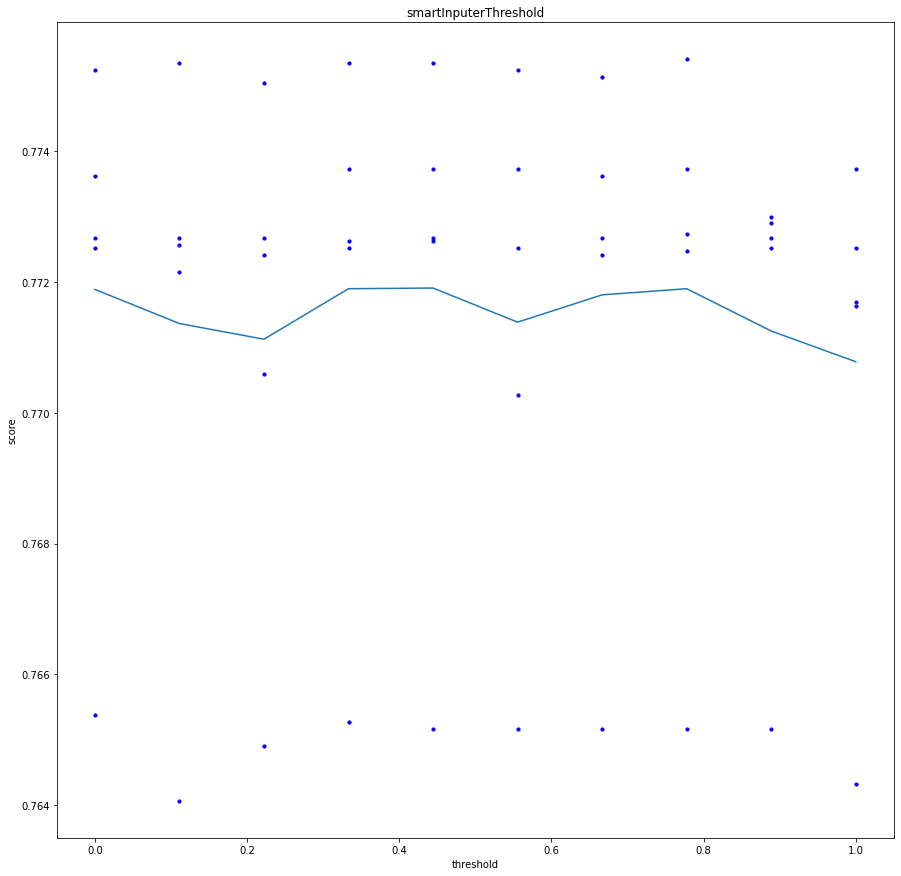

In [ ]:
plotKfold(np.array(xArr), np.array(score), title="smartInputerThreshold", xlabel="threshold", ylabel="score")

## 1.4 Train Val Split

In [ ]:
processedDF.shape

(1451393, 123)

In [ ]:
# RUN 10
# make a train and val split 70% - 30%
dfTrain = processedDF[:len(yTrainFull)]
dfTest = processedDF[len(yTrainFull):]

xTrain, xVal, yTrainSplit, yVal = train_test_split(dfTrain,
                                              yTrainFull,
                                              shuffle=False,
                                              test_size=0.3,
                                              train_size=0.7,
                                              random_state=0)

# 3 Hyper parameter tuning

In [ ]:
# RUN 11
def sampler(x, y, frac=0.1, seed=0):

  random.seed(seed)
  
  sampleIndex = random.sample(range(0, len(y)), 
                            math.floor(frac * len(y)))
  
  return x[sampleIndex, :], y.loc[sampleIndex]

In [ ]:
def run_trials(max_evals, save_iter, space, objective, filename, reset=False):

  # if reset, start from begining

  # attempt to load pickle file
  if not reset:
    try:
      # try to find file
      trials = pickle.load(open(filename, 'rb'))
      print(f"Trials file found.  Resuming from {len(trials.trials)} iterations.")
    except:
      # cant find
      trials = Trials()
      print("No Trials file found, will create new file.")
  
  # Dont attempt to load pickle file
  else:
    print("Reseting, will write over trials file.")
    trials = Trials()
  
  best = trials

  # iter untill max_evals is reached
  i = len(trials.trials)
  while(i < max_evals):
    i = i + save_iter

    print(f"{i} of {max_evals}")
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=i,
                trials=trials)
    
    with open(filename, 'wb') as f:
      pickle.dump(trials, f)
    
    clear_output()
  return best

In [ ]:
def load_trials(filename):
  try:
    trials = pickle.load(open(filename, 'rb'))
  except:
    trials = Trials()
  
  return trials

In [ ]:
def visualize_trials(filename, title):

  randForestSpaceDF = pd.DataFrame()
  inputDump = {}

  trials = load_trials(filename)

  for i in range(len(trials.trials)):
    for key in trials.trials[i]['misc']['vals']: 
      inputDump[key] = trials.trials[i]['misc']['vals'][key][0]

    inputDump['accuracy'] = trials.trials[i]['result']['loss'] * -1
    randForestSpaceDF = randForestSpaceDF.append(inputDump, ignore_index=True)

  fig = px.parallel_coordinates(randForestSpaceDF, color="accuracy", 
                              color_continuous_scale=px.colors.sequential.Blues,
                              title=title)
  fig.show()

In [ ]:
def getBestParam(filename):
  trials = load_trials(filename)
  return trials.best_trial['misc']['vals']

## 3.1 Training Random Forest

In [ ]:
# sections of this function were taken from a hyperopt example I found online
# -aidan

xHyper, yHyper = sampler(xTrain, yTrainSplit, frac=0.1)

# this is bad code sorry

def objective(space):
    
    clf = RandomForestClassifier(**space,
                                 n_jobs = -1)
    
    accuracy = cross_val_score(clf, xHyper, yHyper).mean()

    # we aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'list'>


In [ ]:
# this cell takes like over an hour to run
# its output is hardcoded later on 
#
# bestParam
#
# dont run unless you are a masochistic
# hyperopt is cool and all but its bloody slow
# -aidan

space = {'max_depth': hp.quniform('max_depth', 10, 100, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : pyll.scope.int(hp.quniform('n_estimators', 1, 100, q=1)),}

bestParam = run_trials(max_evals = 100, 
                       save_iter = 10, 
                       space = space,
                       objective = objective, 
                       filename = "/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/randomForestTrials.p", 
                       reset=True)

print(bestParam)

30 of 100
 30%|███       | 3/10 [01:43<04:00, 34.40s/it, best loss: -0.7704835085070182]


KeyboardInterrupt: ignored

In [ ]:
visualize_trials("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/randomForestTrials.p", "randomForest Hyperparameter")

## 3.2 Training XGBClassifier

In [ ]:
# sections of this function were taken from a hyperopt example I found online
# -aidan

xHyper, yHyper = sampler(xTrain, yTrainSplit, frac=0.3)

def objectiveXGB(space):

    clf = xgb.XGBClassifier(**space,
                            n_jobs=-1,
                            use_label_encoder=False,
                            eval_metric = 'auc',
                            objective='binary:logistic',
                            tree_method='gpu_hist',
                            predictor='gpu_predictor')
    
    accuracy = cross_val_score(clf, xHyper, yHyper, cv=4).mean()

    # we aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
spaceXGB = {'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
            'eta': hp.loguniform('eta', -7, 1),
            'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 10, 1)),
            'subsample': hp.uniform('subsample', 0.2, 1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1),
            'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
            'lambda': hp.loguniform('lambda', -16, 2),
            'alpha': hp.loguniform('alpha', -16, 2),
            'gamma': hp.loguniform('gamma', -16, 2)}

bestParamXGB = run_trials(max_evals = 100, 
                       save_iter = 2, 
                       space = spaceXGB,
                       objective = objectiveXGB, 
                       filename = "/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/XGBTrials.p", 
                       reset=False)
print(bestParamXGB)

Trials file found.  Resuming from 100 iterations.


In [ ]:
visualize_trials("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/XGBTrials.p", "XGBoost")

In [ ]:
getBestParam("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/XGBTrials.p")

{'alpha': [0.00020659859387315652],
 'booster': [2],
 'colsample_bylevel': [0.9856035224641746],
 'colsample_bytree': [0.6737881931149096],
 'eta': [0.031551151396881784],
 'gamma': [0.009417649155467262],
 'lambda': [1.0422186845319055e-06],
 'max_depth': [5.0],
 'min_child_weight': [8.892224545136958e-05],
 'subsample': [0.6693822564165557]}

In [ ]:
xgb1_params = {
    'eval_metric' : 'auc',
    'lambda': 0.004562711234493688, 
    'alpha': 7.268146704546314, 
    'colsample_bytree': 0.6468987558386358, 
    'colsample_bynode': 0.29113878257290376, 
    'colsample_bylevel': 0.8915913499148167, 
    'subsample': 0.37130229826185135, 
    'learning_rate': 0.021671163563123198, 
    'grow_policy': 'lossguide', 
    'max_depth': 18, 
    'min_child_weight': 215, 
    'max_bin': 272,
    'n_estimators': 10000,
    'random_state': 0,
    'use_label_encoder': False,
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}

clf = xgb.XGBClassifier(**xgb1_params)

clf.fit(xTrain, yTrainSplit)

XGBClassifier(alpha=7.268146704546314, colsample_bylevel=0.8915913499148167,
              colsample_bynode=0.29113878257290376,
              colsample_bytree=0.6468987558386358, eval_metric='auc', gpu_id=0,
              grow_policy='lossguide', lambda=0.004562711234493688,
              learning_rate=0.021671163563123198, max_bin=272, max_depth=18,
              min_child_weight=215, n_estimators=10000,
              predictor='gpu_predictor', subsample=0.37130229826185135,
              tree_method='gpu_hist', use_label_encoder=False)

## 3.3 Training CatBoost

In [ ]:
# sections of this function were taken from a hyperopt example I found online
# -aidan

xHyper, yHyper = sampler(dfTrain, yTrainFull, frac=0.1)

trainPool = catboost.Pool(xHyper, yHyper)
valPool = catboost.Pool(xVal, yVal)

def objectiveCat(space):

    clf = CatBoostClassifier(**space)
    clf.fit(trainPool,
            verbose=0, 
            eval_set=valPool)
    y_pred = clf.predict_proba(valPool)
    accuracy = eval_metric(valPool.get_label(), y_pred[:, 1], 'auc')[0]

    # we aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
# this cell takes like over an hour to run
# its output is hardcoded later on 
#
# bestParam
#
# dont run unless you are a masochistic
# hyperopt is cool and all but its bloody slow
# -aidan

spaceCat = {'learning_rate': hp.loguniform('learning_rate', -5, 0),
         'random_strength': hp.quniform('random_strength', 1, 20, 1),
         'max_depth': hp.quniform('max_depth', 0, 16, 1),
         'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, 2),
         'bagging_temperature':hp.uniform('bagging_temperature', 0, 1),
         'leaf_estimation_iterations': hp.quniform('leaf_estimation_iterations', 1, 5, 1),
         'iterations': hp.quniform('iterations', 250, 500, 10)}

bestParamCat = run_trials(max_evals = 100,
                          save_iter = 2,
                          space = spaceCat,
                          objective = objectiveCat,
                          filename = "/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/CatTrials.p",
                          reset=False)

print(bestParamCat)

In [ ]:
visualize_trials("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/CatTrials.p", "catboost Hyperparameter")

## 3.4 Training Tabnet

In [ ]:
xHyper, yHyper = sampler(xTrain, yTrainSplit, frac=0.1)

def objectiveTab(space):

    space['searchSpace']['n_a'] = space['searchSpace']['n_d']

    clf = TabNetClassifier(**space['searchSpace'])
    
    clf.fit(xHyper, yHyper,
            eval_set = [(xVal, yVal)],
            eval_metric = ['auc'],
            max_epochs = 75)

    auc = max(clf.history['val_0_auc'])

    # we aim to maximize auc, therefore we return it as a negative value
    return {'loss': -auc, 'status': STATUS_OK }

In [ ]:
spaceTab = {'k': pyll.scope.int(hp.quniform('k', 40, 99, 1)),
            'searchSpace': {'mask_type': hp.choice('mask_type', ["entmax", "sparsemax"]),
                            'n_d': pyll.scope.int(hp.quniform('n_d', 8, 64, 4)),
                            'n_steps': pyll.scope.int(hp.quniform('n_steps', 3, 5, 1)),
                            'gamma': hp.uniform('gamma', 1, 2),
                            'n_independent': pyll.scope.int(hp.quniform('n_independent', 1, 5, 1)),
                            'n_shared': pyll.scope.int(hp.quniform('n_shared', 1, 5, 1)),
                            'momentum': hp.uniform('momentum', 0.01, 0.4),
                            'lambda_sparse': hp.loguniform('lambda_sparse', -6, -3)}}

bestParamTab = run_trials(max_evals = 100, 
                       save_iter = 2, 
                       space = spaceTab,
                       objective = objectiveTab, 
                       filename = "/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/TabTrials.p", 
                       reset=True)
print(bestParamTab)

6 of 100
Device used : cuda
epoch 0  | loss: 0.68606 | val_0_auc: 0.77316 |  0:00:22s
epoch 1  | loss: 0.53252 | val_0_auc: 0.79534 |  0:00:44s
epoch 2  | loss: 0.52757 | val_0_auc: 0.79581 |  0:01:06s
epoch 3  | loss: 0.52645 | val_0_auc: 0.79468 |  0:01:29s
epoch 4  | loss: 0.52615 | val_0_auc: 0.79686 |  0:01:51s
epoch 5  | loss: 0.52317 | val_0_auc: 0.79785 |  0:02:12s
  0%|          | 0/2 [02:25<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

In [ ]:
visualize_trials("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/TabTrials.p", "TabNet")

In [ ]:
bestParam = getBestParam("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/TabTrials.p")
bestParam

{'gamma': [1.2215519222663302],
 'k': [98.0],
 'lambda_sparse': [0.0036912807595016355],
 'mask_type': [0],
 'momentum': [0.33845753977793525],
 'n_d': [28.0],
 'n_independent': [3.0],
 'n_shared': [5.0],
 'n_steps': [5.0]}

## 3.5 LightGBM

In [ ]:
# sections of this function were taken from a hyperopt example I found online
# -aidan

def objectiveLGBM(space):

    if (space['boosting_type'] == 'goss'):
      space['subsample'] = 1

    kf = KFold(n_splits = 5, shuffle = True)

    scores = []

    for train_index, test_index in kf.split(xTrain):

      xTrainSplit, xTestSplit = xTrain[train_index], xTrain[test_index]
      yTrainSplit, yTestSplit = yTrainFull[train_index], yTrainFull[test_index]

      clf = LGBMClassifier(**space)
      clf.fit(xTrainSplit, yTrainSplit,
              verbose=0, 
              eval_set=[(xTestSplit, yTestSplit)])
      y_pred = clf.predict_proba(xVal)[:, 1]

      score = roc_auc_score(yVal, y_pred)
      print(f'LGBM fold auc: {score}')

      scores.append(score)

    # we aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -np.mean(scores), 'status': STATUS_OK }

In [ ]:
spaceLGBM = {'boosting_type': hp.choice('boosting_type', ['gbdt', 'goss', 'dart']),
             'num_leaves': pyll.scope.int(hp.quniform('num_leaves', 20, 150, 10)),
             'learning_rate': hp.loguniform('learning_rate', -6, 1),
             'subsample_for_bin': pyll.scope.int(hp.quniform('subsample_for_bin', 20000, 500000, 20000)),
             'min_child_samples': pyll.scope.int(hp.quniform('min_child_samples', 20, 500, 5)),
             'reg_alpha': hp.uniform('reg_alpha', 0, 1),
             'reg_lambda': hp.uniform('reg_lambda', 0, 1),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
             'subsample': hp.uniform('subsample', 0.5, 1),
             'is_unbalance': hp.choice('is_unbalance', [False, True])}

bestParamLGBM = run_trials(max_evals = 100, 
                       save_iter = 2, 
                       space = spaceLGBM,
                       objective = objectiveLGBM, 
                       filename = "/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/lgbm.p", 
                       reset=True)
print(bestParamLGBM)

16 of 100
LGBM fold auc: 0.7994236326308375
LGBM fold auc: 0.7992654184971124
LGBM fold auc: 0.7997749313546416
LGBM fold auc: 0.7996488862806688
  0%|          | 0/2 [05:02<?, ?it/s, best loss: ?]


KeyboardInterrupt: ignored

In [ ]:
visualize_trials("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/lgbm.p", "LightGBM")

In [ ]:
getBestParam("/content/gdrive/MyDrive/Software/ESOF-0151 Project/hyperparameterTrials/lgbm.p")

{'boosting_type': [0],
 'colsample_bytree': [0.6077154792966379],
 'is_unbalance': [0],
 'learning_rate': [0.08028224397812166],
 'min_child_samples': [385.0],
 'num_leaves': [60.0],
 'reg_alpha': [0.09019592529911713],
 'reg_lambda': [0.08245955371473801],
 'subsample': [0.8360916597569221],
 'subsample_for_bin': [340000.0]}

In [ ]:
spaceLGBM = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.803928347810881,
 'is_unbalance': True,
 'learning_rate': 0.17025191721735602,
 'min_child_samples': 30,
 'num_leaves': 140,
 'reg_alpha': 0.7333444384270381,
 'reg_lambda': 0.5221658401562319,
 'subsample': 0.5786269381707934,
 'subsample_for_bin': 380000}

clf = LGBMClassifier(**spaceLGBM)
clf.fit(xTrain, yTrainSplit,
        verbose=0, 
        eval_set=[(xVal, yVal)])

LGBMClassifier(colsample_bytree=0.803928347810881, is_unbalance=True,
               learning_rate=0.17025191721735602, min_child_samples=30,
               num_leaves=140, reg_alpha=0.7333444384270381,
               reg_lambda=0.5221658401562319, subsample=0.5786269381707934,
               subsample_for_bin=380000)

# 4 Model Training

A collection of diffrent output methods, only use *one*

## 4.1 Basic Random Forest

In [ ]:
  bestParamRF = {'criterion': 'gini', 
            'max_depth': 10, 
            'max_features': 'sqrt', 
            'min_samples_leaf': 0.024684704247566212, 
            'min_samples_split': 0.26868411877216003, 
            'n_estimators': 85,
            'n_jobs': -1}  

clf = RandomForestClassifier(**bestParamRF)
clf.fit(xTrain, yTrainSplit)

## 4.2 Tabnet

In [ ]:
bestParamTab = {'gamma': 1.2215519222663302,
                'lambda_sparse': 0.0036912807595016355,
                'mask_type': 'entmax',
                'momentum': 0.33845753977793525,
                'n_d': 28,
                'n_independent': 3,
                'n_shared': 5,
                'n_steps': 5}

clf = TabNetClassifier(**bestParamTab)

clf.fit(xTrain, yTrainSplit,
        eval_set = [(xVal, yVal)],
        eval_metric = ['auc'],
        max_epochs = 75)

Device used : cuda
epoch 0  | loss: 0.5324  | val_0_auc: 0.7963  |  0:02:10s
epoch 1  | loss: 0.51515 | val_0_auc: 0.79872 |  0:04:22s
epoch 2  | loss: 0.5144  | val_0_auc: 0.79796 |  0:06:30s
epoch 3  | loss: 0.51399 | val_0_auc: 0.79909 |  0:08:37s
epoch 4  | loss: 0.51368 | val_0_auc: 0.79927 |  0:10:44s
epoch 5  | loss: 0.51374 | val_0_auc: 0.79954 |  0:12:53s
epoch 6  | loss: 0.51383 | val_0_auc: 0.79941 |  0:15:02s
epoch 7  | loss: 0.51357 | val_0_auc: 0.79984 |  0:17:10s
epoch 8  | loss: 0.51355 | val_0_auc: 0.79805 |  0:19:18s
epoch 9  | loss: 0.51354 | val_0_auc: 0.7989  |  0:21:25s
epoch 10 | loss: 0.51341 | val_0_auc: 0.79844 |  0:23:37s
epoch 11 | loss: 0.51348 | val_0_auc: 0.79833 |  0:25:47s
epoch 12 | loss: 0.51335 | val_0_auc: 0.7987  |  0:27:56s
epoch 13 | loss: 0.51339 | val_0_auc: 0.7989  |  0:30:03s
epoch 14 | loss: 0.51329 | val_0_auc: 0.79931 |  0:32:14s
epoch 15 | loss: 0.51325 | val_0_auc: 0.79949 |  0:34:22s
epoch 16 | loss: 0.51328 | val_0_auc: 0.79956 |  0:36

## 4.2 Model Stacking

In [ ]:
# model params
bestParamXGB1 = {
    'alpha': 3.0098950557831317e-06, 
    'colsample_bylevel': 0.8888223977605876, 
    'colsample_bytree': 0.6629640277225338, 
    'eta': 0.005710790861655478, 
    'gamma': 0.0071953427713228905, 
    'lambda': 5.204086077282118e-06, 
    'max_depth': 5, 
    'min_child_weight': 106.36834970939083, 
    'subsample': 0.7639245020607291,
    'n_jobs': -1,
    'eval_metric' : 'auc',
    'random_state': 0,
    'use_label_encoder': False,
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'}

bestParamXGB2 = {
    'eval_metric' : 'auc',
    'lambda': 0.004562711234493688, 
    'alpha': 7.268146704546314, 
    'colsample_bytree': 0.6468987558386358, 
    'colsample_bynode': 0.29113878257290376, 
    'colsample_bylevel': 0.8915913499148167, 
    'subsample': 0.37130229826185135, 
    'learning_rate': 0.021671163563123198, 
    'grow_policy': 'lossguide', 
    'max_depth': 18, 
    'min_child_weight': 215, 
    'max_bin': 272,
    'n_estimators': 10000,
    'random_state': 0,
    'use_label_encoder': False,
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor'
}


bestParamRF = {
    'criterion': 'gini', 
    'max_depth': 10, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 0.024684704247566212, 
    'min_samples_split': 0.26868411877216003, 
    'n_estimators': 85,
    'n_jobs': -1
}    

bestParamTab = {
    'gamma': 1.2215519222663302,
    'lambda_sparse': 0.0036912807595016355,
    'mask_type': 'entmax',
    'momentum': 0.33845753977793525,
    'n_d': 28,
    'n_independent': 3,
    'n_shared': 5,
    'n_steps': 5,
    'verbose': 0
}

bestParamLGBM1 = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.803928347810881,
    'is_unbalance': True,
    'learning_rate': 0.17025191721735602,
    'min_child_samples': 30,
    'num_leaves': 140,
    'reg_alpha': 0.7333444384270381,
    'reg_lambda': 0.5221658401562319,
    'subsample': 0.5786269381707934,
    'subsample_for_bin': 380000
}

bestParamLGBM2 = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.6077154792966379,
    'is_unbalance': False,
    'learning_rate': 0.08028224397812166,
    'min_child_samples': 385,
    'num_leaves': 60,
    'reg_alpha': 0.09019592529911713,
    'reg_lambda': 0.08245955371473801,
    'subsample': 0.8360916597569221,
    'subsample_for_bin': 340000
}


class TabNetClassifierWrapper(BaseEstimator, ClassifierMixin):
  '''TabNet is special and needs a wrapper to work properly with sklearns
  stacking classifier.

  space (dict): the search space for tabnet
  eval (list of tuple): a list of x & y validation sets
  
  '''
  def __init__(self, space, eval_set, eval_metric, max_epochs):

    self.space = space
    self.eval_set = eval_set
    self.eval_metric = eval_metric
    self.max_epochs = max_epochs

    self.clf = TabNetClassifier(**self.space)

  def fit(self, x, y=None):

    self.clf.fit(x, y,
                 eval_set = self.eval_set,
                 eval_metric = self.eval_metric,
                 max_epochs = self.max_epochs)
    
    return self
  
  def predict(self, x, y=None):
    return self.clf.predict(x)


class LGBMClassifierWrapper(BaseEstimator, ClassifierMixin):
  '''LGBM is special and needs a wrapper to work properly with sklearns
  stacking classifier.

  space (dict): the search space for lgbm
  
  '''
  def __init__(self, space, eval_set, eval_metric):

    self.space = space
    self.eval_set = eval_set
    self.eval_metric = eval_metric

    self.clf = LGBMClassifier(**self.space)

  def fit(self, x, y=None):

    self.clf.fit(x, y,
                 eval_set = self.eval_set,
                 eval_metric = self.eval_metric,
                 verbose = 0)
    
    return self
  
  def predict(self, x, y=None):
    return self.clf.predict(x)


In [ ]:
estimators = [('xgbClf1', xgb.XGBClassifier(**bestParamXGB1)),
              ('xgbClf2', xgb.XGBClassifier(**bestParamXGB2)),
              ('LGBM1', LGBMClassifierWrapper(space = bestParamLGBM1,
                                              eval_set = [(xVal, yVal)],
                                              eval_metric = ['auc'])),
              ('LGBM2', LGBMClassifierWrapper(space = bestParamLGBM2,
                                              eval_set = [(xVal, yVal)],
                                              eval_metric = ['auc']))]

finalEstimator = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)

clf = StackingClassifier(estimators=estimators, 
                         final_estimator=finalEstimator,
                         cv = 2)

In [ ]:
clf.fit(xTrain, yTrainSplit)

StackingClassifier(cv=2,
                   estimators=[('xgbClf1',
                                XGBClassifier(alpha=3.0098950557831317e-06,
                                              colsample_bylevel=0.8888223977605876,
                                              colsample_bytree=0.6629640277225338,
                                              eta=0.005710790861655478,
                                              eval_metric='auc',
                                              gamma=0.0071953427713228905,
                                              lambda=5.204086077282118e-06,
                                              max_depth=5,
                                              min_child_weight=106.36834970939083,
                                              n_jobs=-1,
                                              predictor='gpu_predictor',
                                              sub...
                                                      space={'boosting_type'

## 4.3 SVM Model

In [ ]:
clf = svm.SVC(kernel='linear', C =0.001)
clf.fit(xTrain, yTrainSplit)

# 5 Output

In [ ]:
clf.score(xVal, yVal)

0.7725349368075274

In [ ]:
submission = pd.DataFrame()
submission['id'] = TestID
submission['claim'] = clf.predict(dfTest)
submission.to_csv('submission.csv',index=False)